# Анализ бизнес-показателей

## Описание проекта

**Цель - разобраться в причинах убытков развлекательного приложения P Pro+ с мая по июнь 2019 г, в течение которых проводилась рекламная кампания.**

**Задачи:**
- узнать как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент,
- когда он окупается
- какие факторы отрицательно влияют на привлечение пользователей.

**Данные для анализа:**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах в период с 2019-05-01 по 2019-10-27):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


## Подготовка данных к анализу

Загрузим данные о визитах, заказах и расходах в переменные. Оценим их, оптимизируем  данные для анализа, приведем к нужным типам. 

In [2]:
# загружаем
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
)

In [3]:
# функция для предварительного обзора данных
def preview (data):
    print('Посмотрим на данные')
    print('-'*50)
    display(data.head())
    print('Атрибуты')
    print('-'*50)
    print(data.info())
    print('Пропусков в данных')
    print('-'*50)
    print(data.isna().sum())
    print('Полных дубликатов в данных')
    print('-'*50)
    print(data.duplicated().sum())
           

### Таблица visits
Хранит логи с информацией о посещениях сайта новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27

In [4]:
preview(visits)

Посмотрим на данные
--------------------------------------------------


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Атрибуты
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Пропусков в данных
--------------------------------------------------
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
Полных дубликатов в данных
--------------------------------------------------
0


В таблице пропусков и полных дубликатов нет. Нужно переписать названия столбцов, привети к нужному типу данные о времени, проверить столбцы Region, Device и Channel на неявные дубликаты. 

In [5]:
# переписываем названия столбцов к змеином регистре
visits.columns=['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [6]:
# смотрим уникальные значения
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [7]:
# смотрим уникальные значения
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [8]:
# смотрим уникальные значения
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Неявных дубликатов нет. Написание регионов и девайсов оставим прежним (читаются без проблем), названия в channel - приведем к нижнему регистру, т.к. очень тяжело читаются

In [9]:
# приводим к нижнему регистру
visits['channel'] = visits['channel'].str.lower()

In [10]:
# приводим к datetime столбцы с датами и временем
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

### Таблица orders
Информация о заказах в период с 2019-05-01 по 2019-10-27

In [11]:
preview(orders)

Посмотрим на данные
--------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Атрибуты
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Пропусков в данных
--------------------------------------------------
User Id     0
Event Dt    0
Revenue     0
dtype: int64
Полных дубликатов в данных
--------------------------------------------------
0


В таблице пропусков и полных дубликатов нет. Также нужно переписать названия столбцов и привети к нужному типу данные о времени.

In [12]:
# передаем названия столбцов в змеином регистре
orders.columns = ['user_id', 'event_dt', 'revenue']
# приводим к datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

### Таблица costs
Информация о затратах на маркетинг

In [13]:
preview(costs)

Посмотрим на данные
--------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Атрибуты
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Пропусков в данных
--------------------------------------------------
dt         0
Channel    0
costs      0
dtype: int64
Полных дубликатов в данных
--------------------------------------------------
0


Пропусков и полных дубликатов нет, перепишем название столбца Channel, приведем к нужному типу данные о дате. Посмотрим на неявные дубли столбец channel.

In [14]:
# переписываем название столбца
costs = costs.rename(columns={'Channel':'channel'})
# приводим к datetime
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [15]:
# смотрим уникальные значения
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявных дубликатов нет, читается в таком виде тяжело - приведем к нижнему регистру.

In [16]:
# приводим к нижнему регистру
costs['channel'] = costs['channel'].str.lower()

### Вывод

- Данные в таблицах чистые, без пропусков и дубликатов, неявные дубли в ходе проверки также не были выявлены.
- Название столбцов в таблицах приведено к змеиному регистру.
- Для удобства восприятия привели к нижнему регистру название каналов (visits, costs)
- Все данные о времени из object перевели в datetime.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

В анализе будем использовать готовые функции метрик и их визуализации (из курса "Аналитик баз данных" - ЯндексПрактикум)

### Зададим функции метрик

In [17]:
# функция для создания пользовательских профилей

def get_profiles_cac(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [18]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Зададим функции для визуализации метрик

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?
- Совместим данные по странам, каналам и устройствам и сделаем выводы

### Исследование пользователей по странам, источникам и используемым устройствам

Мы знаем, что в visits и orders данные с 1 мая по 27 октября, посмотрим какой период охватывает таблица costs

In [25]:
# даты первых покупок пользователя
first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
print(first_orders['event_dt'].agg({'min', 'max'}))

min   2019-05-01 00:28:11
max   2019-10-31 22:46:19
Name: event_dt, dtype: datetime64[ns]


In [26]:
# даты расходов на рекламу
costs['dt'].agg({'min', 'max'})

min    2019-05-01
max    2019-10-27
Name: dt, dtype: object

У нас есть данные о первых покупках пользователей с 1 мая 2019 года по 31 октября 2019 года, информация о рекламных вложениях есть за период с 1 мая по 27 октября. При создании профиля пользователей мы объединим таблицы и уберем те дни, по которым нет информации о тратах на рекламу, для того чтобы проверить, где проседает показатель прибыли по полным данным (привлечение пользователя, расход на рекламу в разрезе пользователя).

In [27]:
# получаем пользовательские профили
profiles = get_profiles_cac (visits,orders,costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [28]:
# проверка дат
print(profiles['dt'].agg({'min', 'max'}))

min    2019-05-01
max    2019-10-27
Name: dt, dtype: object


Посмотрим профили в разрезе стран, девайсов и рекламных каналов, из которых пришел пользователь. Органических пользователей отфильтровывать не будем, важно посмотреть соотношение органиков и привлеченных за деньги пользователей.

,count,sum,mean
region,,,
United States,100002,6902,0.069019
Germany,14981,616,0.041119
UK,17575,700,0.039829
France,17450,663,0.037994


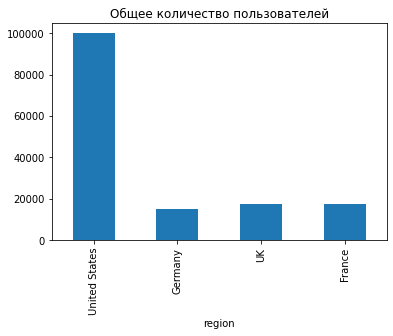

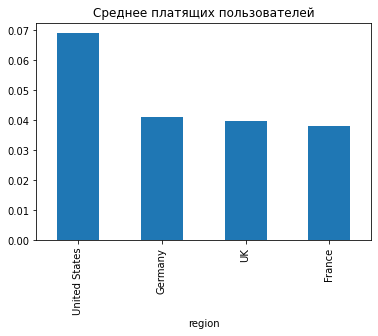

,count,sum,mean
device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


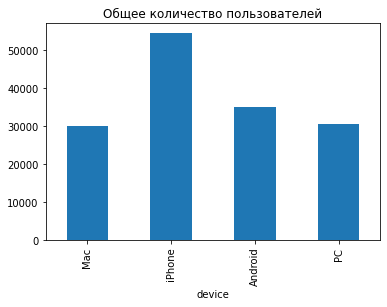

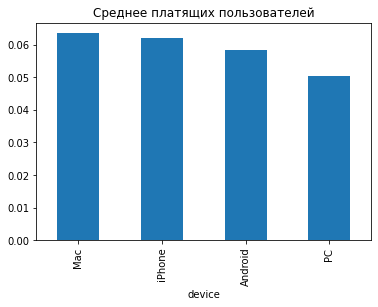

,count,sum,mean
channel,,,
faceboom,29144,3557,0.122049
adnonsense,3880,440,0.113402
lambdamediaads,2149,225,0.104700
tiptop,19561,1878,0.096007
rocketsuperads,4448,352,0.079137
wahoonetbanner,8553,453,0.052964
yrabbit,4312,165,0.038265
mediatornado,4364,156,0.035747
leapbob,8553,262,0.030633


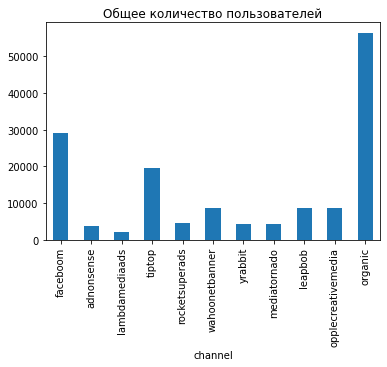

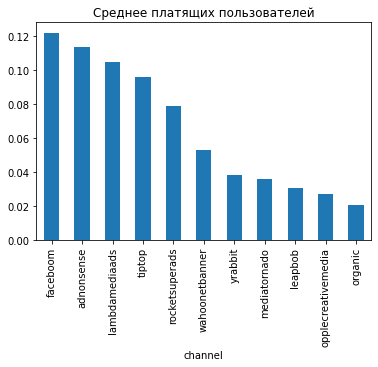

In [29]:
# пользовательска история по каналам привлечения, устройству и стране, в разрезе платящих пользователей 
# столбец 'payer' - в булевом типе, можем его "посчитать": True (платящие, сделавшие заказ) = 1 , False (не платящие) = 0
history = ['region', 'device', 'channel']

for i in history:
    profile_story = profiles.groupby(i)['payer'].agg({'count', 'sum', 'mean'}).sort_values(by=['mean'], ascending=False)
    display(profile_story)
    profile_story['count'].plot(kind='bar')
    plt.title('Общее количество пользователей')
    plt.show()
    profile_story['mean'].plot(kind='bar')
    plt.title('Среднее платящих пользователей')
    plt.show()

**Страны:**
- по количеству пользователей заметно лидирует США с 100002 уникальными ID
- у Германии, Великобритании и Франции близкие показатели, в сумме дают примерно 50000 уникальных ID, что вдвое меньше показателей США
- доля платящих пользователей невысокая, не превышает 10 % во всех странах: лидируют так же США около 7%, в Германии меньшее количество пользователей, но доля платящих больше, чем в Великобритании и Франции

**Выводы:**
- посмотреть, есть ли возможность увеличить долю платных пользователей в США
- посмотреть, есть ли причины такого отставания в количестве привлеченных пользователей в остальных странах


**Устройства:**
- По общему количеству пользователей лидирует iPhone с почти 55000 уникальных ID, на втором месте Android c 35000 уникальных ID 
- По доле платящих ситуация примерно ровная 6% - Mac и iPhone, 5% - Android и PC

**Выводы:**
- большее количество пользователей приложения используют технику Apple
- посмотреть, есть ли возможность увеличить долю платных пользователей на Android

In [30]:
# доля привлеченных пользователей за деньги
profiles.query('channel != "organic"')['user_id'].count()/len(profiles)

0.6237600661298064

**Каналы привленения пользователей**
- в разрезе по каждому источнику привлечения в отдельности- больше всего тех клиентов - 56493, которые пришли сами по себе, бесплатно для компании (organic), но среди них меньше всего платящих пользователей
- сумма всех пользователей привлеченных за деньги по другим каналам, все же больше чем organic - 93659
- много пользователей приносят faceboom и tiptop
- по платящим пользователям лидирует также faceboom  - платящих 12%
- высокие показатели по платящим пользователям у adnonsense - 11% и lambdamediaads - 10% - при этом у них самое меньшее количество привлеченных пользователей

**Выводы:**
- Хорошая доля органических пользователей, значит приложение нравится и срабатывает "сарафанное радио"
- Хороший показатель платящей аудитории у adnonsense и lambdamediaads, посмотреть как можно увеличить привленение пользователей по этим каналам

### Сводные таблицы и визуализация

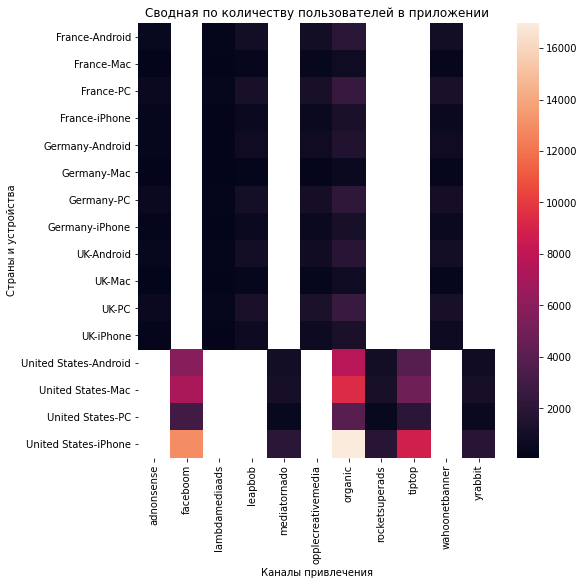

In [31]:
plt.figure(figsize=(8, 8))
sns.heatmap(profiles.pivot_table(index=['region', 'device'], columns='channel', values='user_id', aggfunc='count'))
plt.title('Сводная по количеству пользователей в приложении')
plt.xlabel('Каналы привлечения')
plt.ylabel('Страны и устройства')
plt.show()

- По тепловой карте мы видим, что есть каналы привлечения которые работают только для определенных стран, совместная аудитория из всех стран только у органических пользователей, причем органических пользователей из США значительно больше, чем из других стран. Кроме того большая часть органиков пришли, используя технику Apple (iPhone и Mac).
- Исключая органиков в США больше всего пользователей приходят в приложение из faceboom и tiptop
- Среди Европейских стран, представленных в наших данных, по количеству привлеченных пользователей (кроме органиков) немного впереди: leapbob, opplecreativemedia и wahoonetbanner
- По устройствам: в США - большинство пользователей использует технику Apple (iPhone и Mac), в Европе популярнее Android и PC.

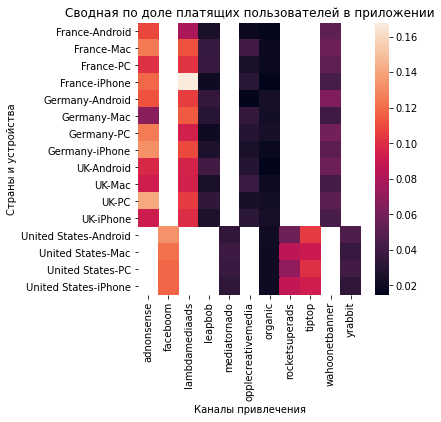

In [32]:
plt.figure(figsize=(5, 5))
sns.heatmap(profiles.pivot_table(index=['region', 'device'], columns='channel', values='payer', aggfunc='mean'))
plt.title('Сводная по доле платящих пользователей в приложении')
plt.xlabel('Каналы привлечения')
plt.ylabel('Страны и устройства')
plt.show()

- В США высокая доля платящих пользователей из faceboom, tiptop и rocketssuperads
- В Европе высокая доля платящих пользователей из adnonsense, lambdamediaads и wahoonetbanner.
- Используемые устройства: доля платящих пользователи из lambdamediaads больше всего у владельцев айфонов из Франции, и в целом платящие пользователи из  lambdamediaads  во Франции и Германии предпочитают технику Apple.
- Европейские платящие пользователи из  wahoonetbanner предпочитают Android и PC

### Вывод

Совместив данные, мы увидели что США и страны Европы привлекаются по абсолютно разным каналам. Такой результат скорее всего связан с популярностью тех или иных каналов в регионах, и соответственно рекламными компаниями только на определенные каналы в разных регионах продаж.

Далее нужно посмотреть вложения в рекламу: действительно ли компания платила за рекламу адресно по популярным платформам в регионе продаж, и если нет - то значит эта рекламная кампания на некоторых платформах в некоторых регионах в контексте первого визита пользователя в приложение не сработала вообще!

По устройствам в США закономерно много пользователей использует iPhone и Mac, в Европе немного более предпочтительнее выглядят устройства на Andriod и PC. Хотя в разрезе платящих пользователей по странам и приложениям есть исключения и совершенно противоположные результаты (на данном этапе подробно на них останавливаться не будем).

## Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [33]:
# общая сумма рекламных расходов
profiles['acquisition_cost'].sum()

105497.29999999999

In [34]:
# средний CAC на одного пользователя для всего проекта
profiles['acquisition_cost'].mean()

0.7032778251826568

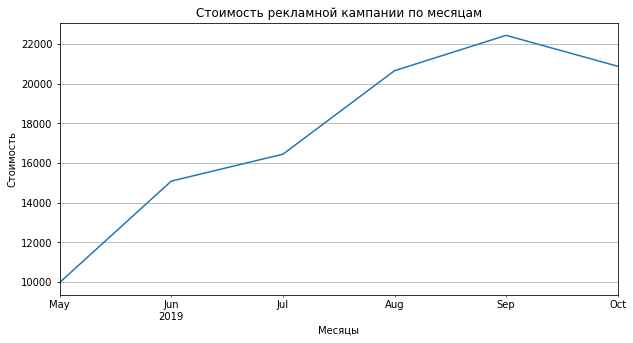

In [35]:
#стоимость рекламной кампании по месяцам
plt.figure(figsize=(10, 5))
profiles.groupby('month')['acquisition_cost'].sum().plot(grid=True)
plt.title('Стоимость рекламной кампании по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Стоимость')
plt.show()

С мая по сентябрь рекламные расходы увеличивались, далее компания начала их снижать: бизнес несет убытки, много вкладывает в рекламу, но который месяц не видит отдачи, поэтому расходы на рекламу начали снижать

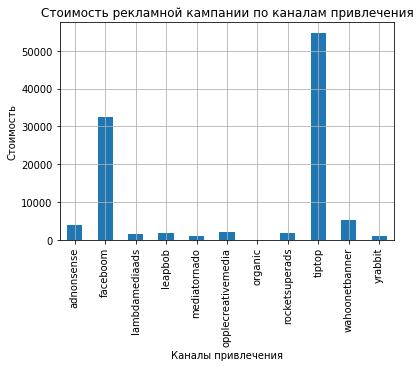

In [36]:
# разбивка рекламных расходов по каналам
profiles.groupby('channel')['acquisition_cost'].sum().plot(kind='bar', grid=True)
plt.title('Стоимость рекламной кампании по каналам привлечения')
plt.xlabel('Каналы привлечения')
plt.ylabel('Стоимость')
plt.show()

In [37]:
# средняя стоимость привлечения пользователя по каналам
acquisition_cost_mean_channel = profiles.groupby('channel')['acquisition_cost'].mean().reset_index().sort_values(
    by='acquisition_cost', ascending=False
).rename(columns={'acquisition_cost':'acquisition_cost_mean_per_channel'})
acquisition_cost_mean_channel

,channel,acquisition_cost_mean_per_channel
8,tiptop,2.799003
1,faceboom,1.113286
0,adnonsense,1.008054
2,lambdamediaads,0.724802
9,wahoonetbanner,0.602245
7,rocketsuperads,0.412095
5,opplecreativemedia,0.250000
10,yrabbit,0.218975
4,mediatornado,0.218717
3,leapbob,0.210172


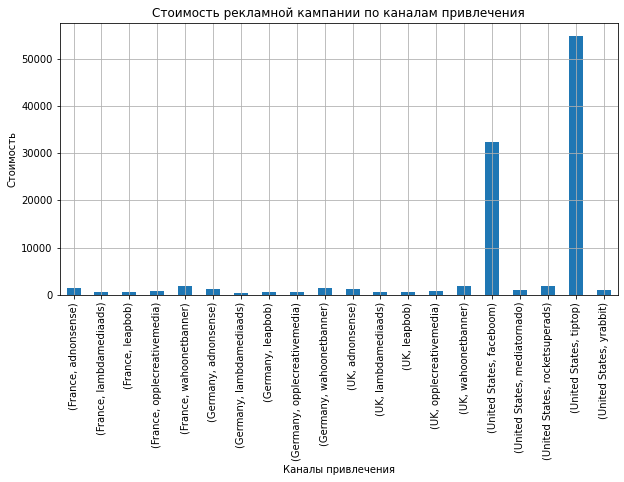

In [38]:
# распределение рекламных расходов по странам и каналам
plt.figure(figsize=(10, 5))
profiles.query('channel != "organic"').groupby(['region', 'channel'])['acquisition_cost'].sum().plot(kind='bar', grid=True)
plt.title('Стоимость рекламной кампании по каналам привлечения')
plt.xlabel('Каналы привлечения')
plt.ylabel('Стоимость')
plt.show()

### Вывод

Всего на рекламу с мая по октябрь (27.10) было израсходовано 105497 (видимо $)

Расходы на рекламу увеличивали с 10000 долларов в мае, до 22000 долларов в сентябре, затем расходы начали снижать.

Действительно рекламные кампании проводились с разбивкой каналов привлечения по США и странам Европы (скорее всего выбирая каналы для рекламы ориентировались на более популярные в США и Европе). 

Самые большие рекламные бюджеты были вложены в два канала привлечения США (faceboom более 30000$ и tiptop - около 55000$), средние расходы на привлечение пользователя из tiptop тоже выше - в это же время процент платящих пользователей в tiptop меньше не только faceboom, но и двух "европейских" платформ - adnonsense и lambdanediaads.

Далее нужно будет проверить то, как окупились рекламные кампании, насколько качественную аудиторию привлекли разные платформы.

## Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

In [39]:
# зададим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Проанализируйте общую окупаемость рекламы

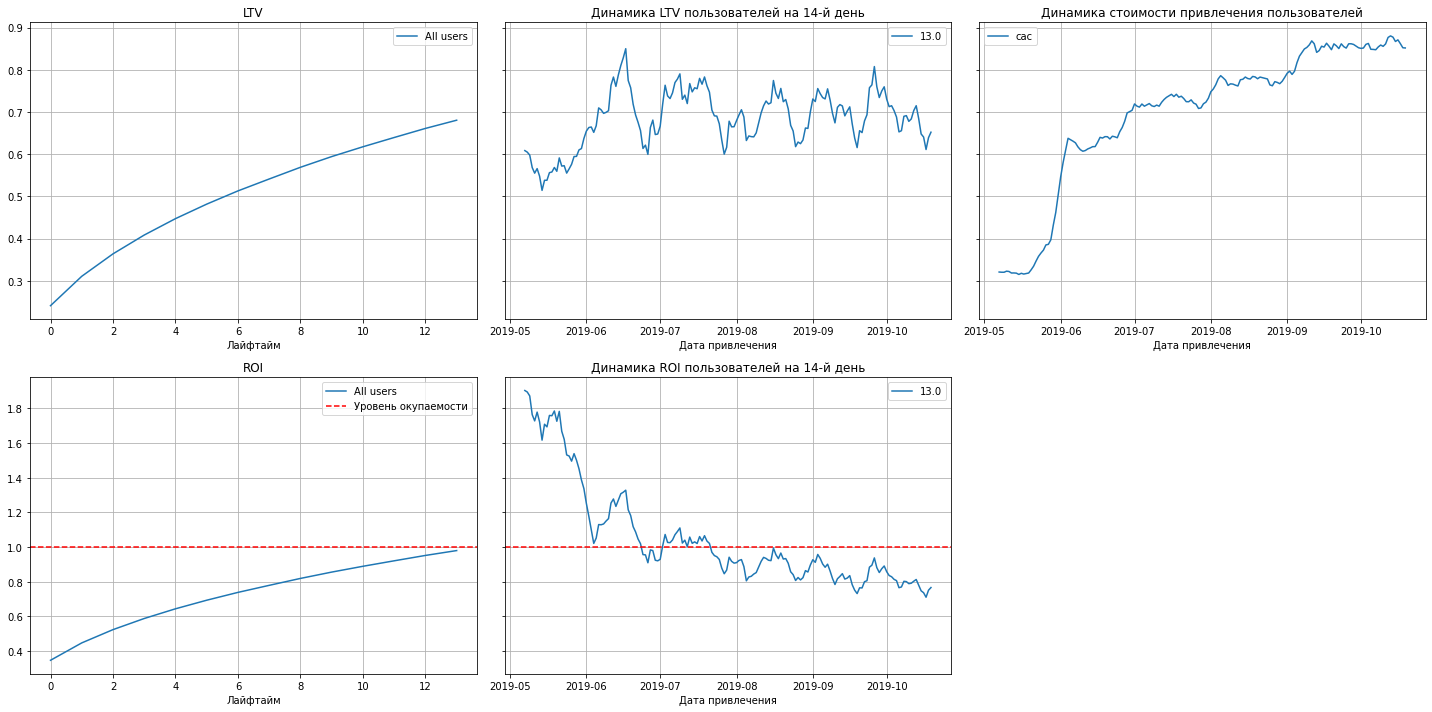

In [40]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Рекламная кампания при постоянном росте расходов так и не окупилась, при этом постоянно росла стоимость привлечения пользователя. Показатели пожизненной ценности пользователя обнадеживают, к концу двуз недель около 70%. Будем искать причины убытков.

Динамика ROI на 14 день в мае была высокой, по результатам скорее всего было принято увеличивать расходы на рекламу, но с июля ROI в динамике на 14 день уходит вниз, под границу окупаемости.

Из наших данных мы можем выделить дополнительные параметры: регион, канал привлечения и устройство, - по которым посмотрим окупаемость, а также оценим конверсию и показатель удержания клиентов.

### Проанализируйте окупаемость рекламы с разбивкой по регионам и странам

Мы уже выяснили, что самый большой рекламный бюджет ушел в США.
- сначала посмотрим на сгруппированные данные по категориям - США и Европа
- далее подробно разберем каждую страну

#### Окупаемость рекламы с разбивкой по группам: США и Европа

In [41]:
# функция для категоризации данных
def region_group(region):
    if region == 'United States':
        return 'USA'
    return 'Europe'

In [42]:
profiles_group = profiles

In [43]:
# применяем функцию и смотрим на получившееся распределение
profiles_group['region_group'] = profiles_group['region'].apply(region_group)
profiles_group['region_group'].value_counts()

USA       100002
Europe     50006
Name: region_group, dtype: int64

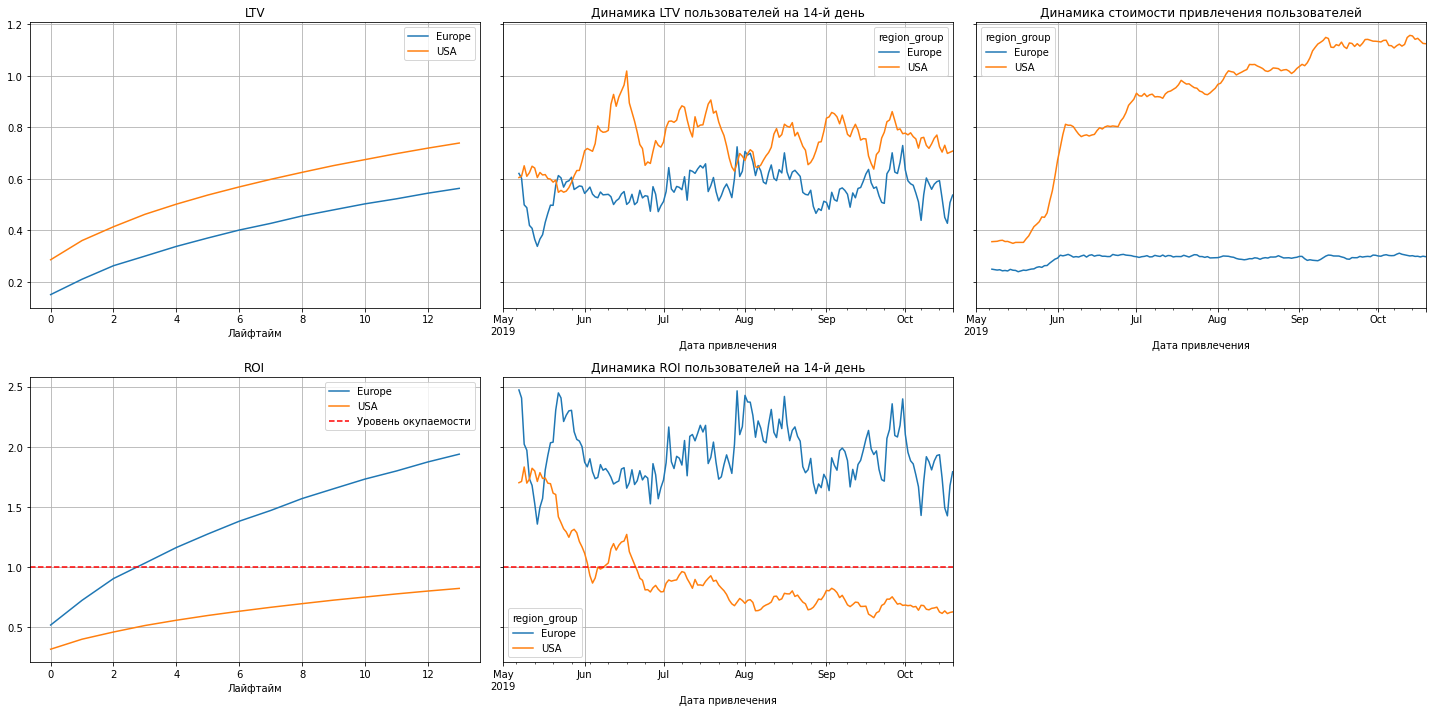

In [44]:
# посмотрим на LTV, ROI  по США и Европе
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_group, orders, observation_date, horizon_days, dimensions=['region_group']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Стоимость привлечения пользователей в США  во много раз больше, чем в Европе, проекция потенциального дохода (LTV) США также превосходит европейский показатель, и при этом рекламная кампания в США далека от окупаемости. В то же время в Европе стоимость привлечения пользователей невысокая, реклама окупилась, с 3 дня показатель ROI растет от границы окупаемости к практически 200% в конце двух недель.

Далее посмотрим конверсию и удержание

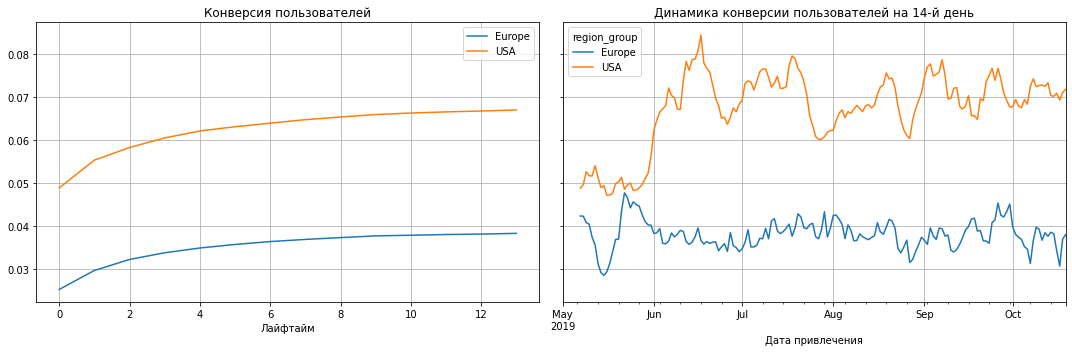

In [45]:
# смотрим конверсию США и Европы

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_group, orders, observation_date, horizon_days, dimensions=['region_group']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


Пользователи США конвертируются стабильно высоко, намного хуже выглядит конверсия европейских пользователей, но и ее показатель достаточно стабилен.

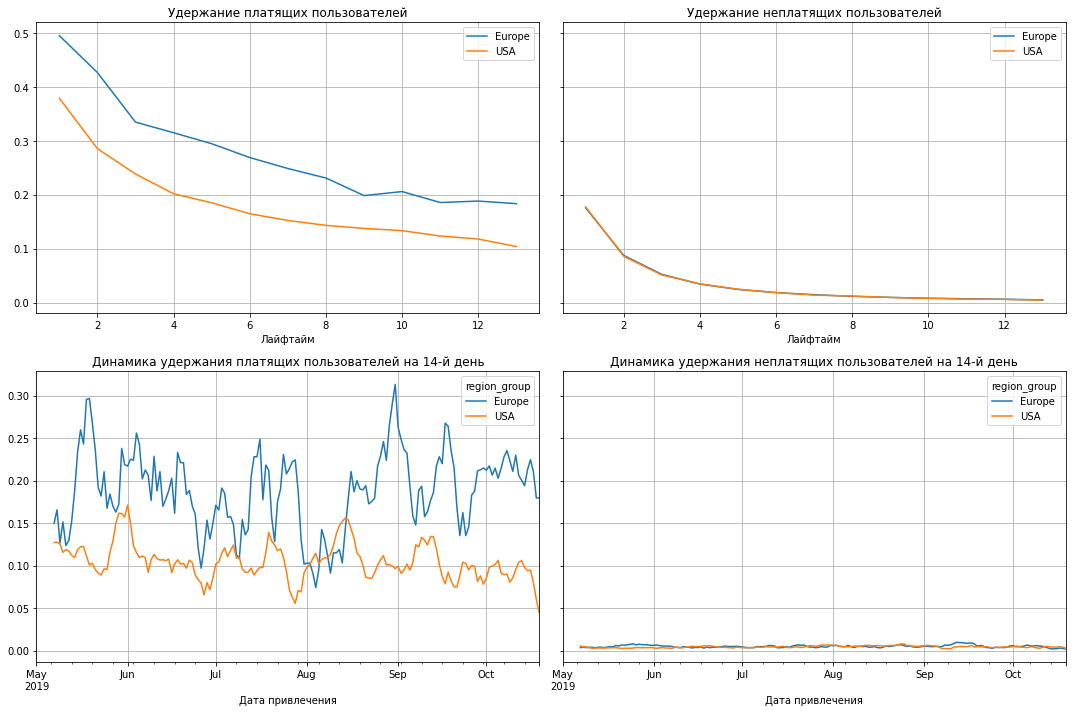

In [46]:
# смотрим удержание США и Европы

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_group, visits, observation_date, horizon_days, dimensions=['region_group']
)

plot_retention(retention_grouped, retention_history, horizon_days)

А вот удержание платящих пользователей в США гораздо хуже. Только в первой половине августа удержание платных пользователей обошло европейский показатель.

#### Окупаемость рекламы с разбивкой по странам

Общая ситуация по регионам понятна, теперь подробнее посмотрим на страны Европы: Франция, Великобритания и Германия

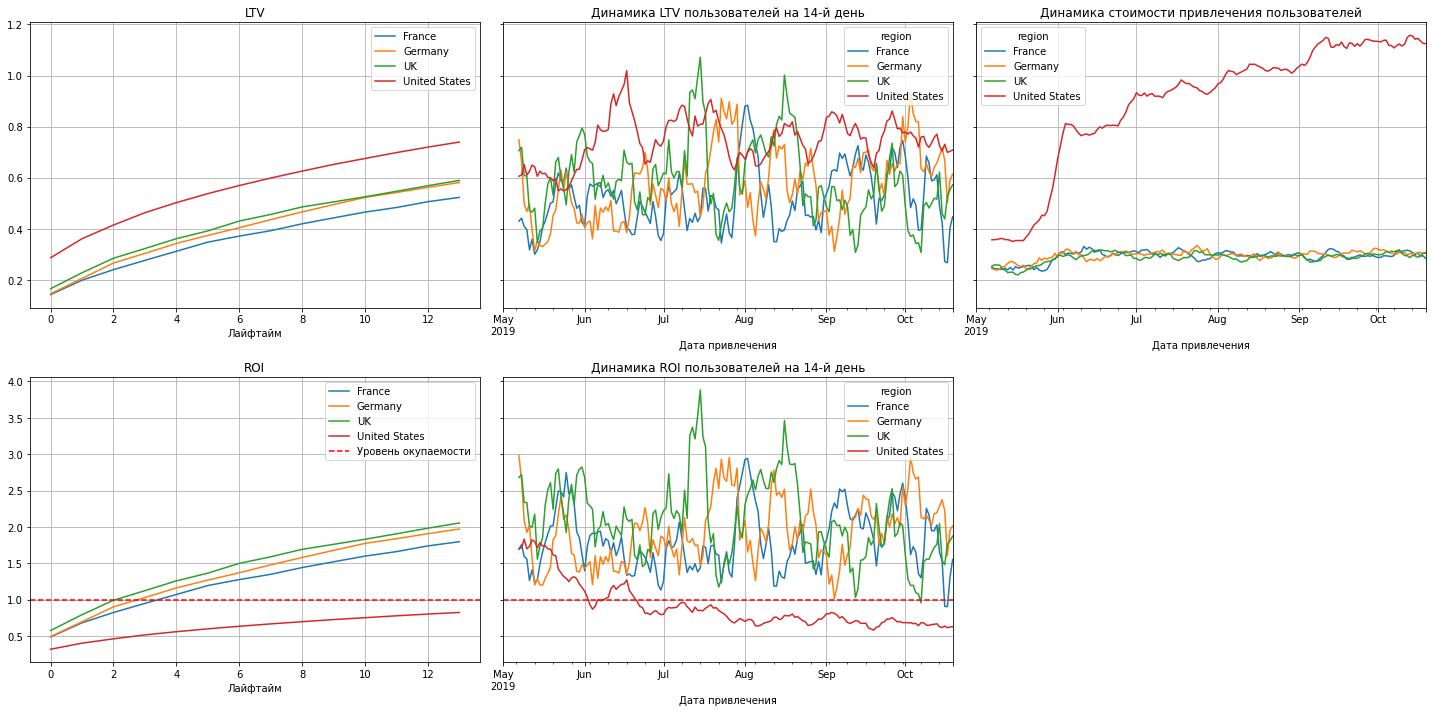

In [47]:
# смотрим LTV, ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Великобритания ненамного опережает по окупаемости Германию и Францию. Пожизненная ценность пользователя (LTV) близки у Германии и Великобритании. В целом показатели трех стран по каждому критерию близки друг к другу.

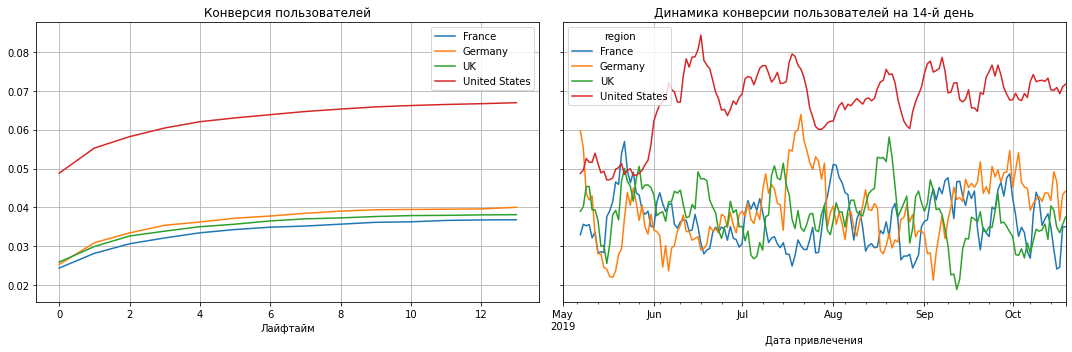

In [48]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


То же с конверсией, показатели стран очень близки, ненамного лучше конвертируются пользователи из Германии.

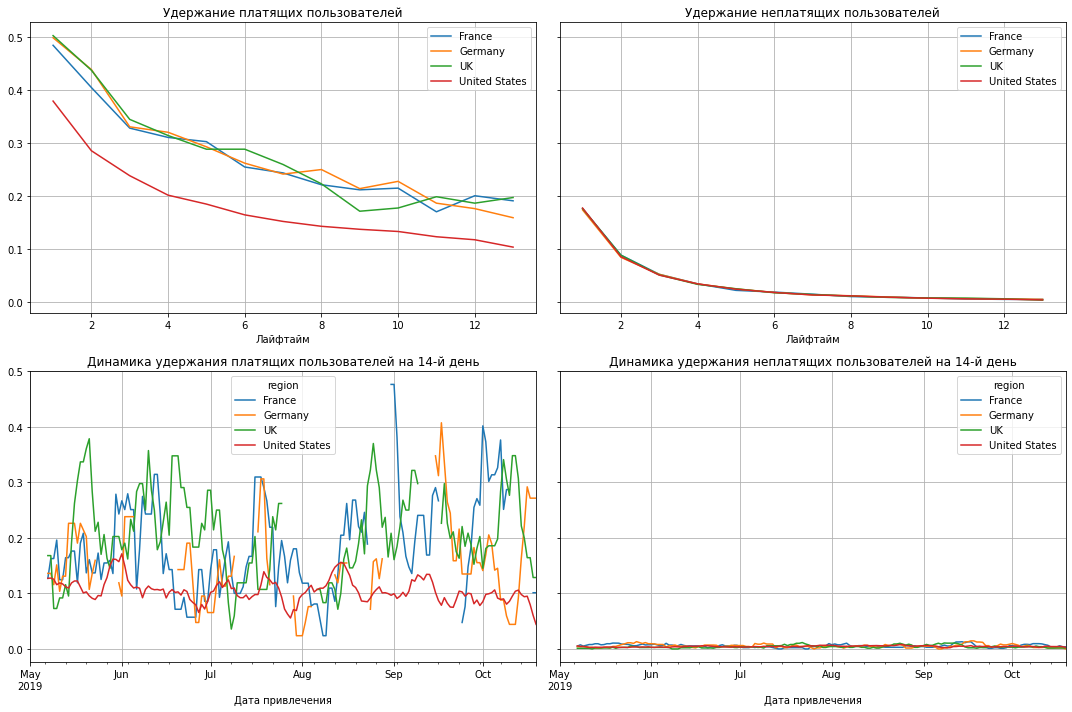

In [49]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Близкие показатели по удержанию.

#### Вывод

Так как показатели LTV, конверсии и удержания в европейских странах отличаются несущественно, сделаем общий вывод по категориям США и Европа.

- Рекламный бюджет, потенциальная доходность и конверсия для пользователи из США значительно превышают те же параметры для Европейского пользователя. Но окупается реклама только в Европе. Причина - низкий показатель удержания в США.

### Окупаемость рекламы с разбивкой по рекламным каналам

Все рекламные каналы мы можем разделить, на те, через которые привлекали пользователей из США и на те, через которые привлекали европейцев. Но выделять категории в этом случае мы не будем, так как уже видели выдающиеся показатели по количеству привлеченных пользователей двух платформ ориентированных на рынок США - Faceboom и Tiptop, чтобы они не перетягивали показатели, разберем сразу каждую платформу в отдельности.

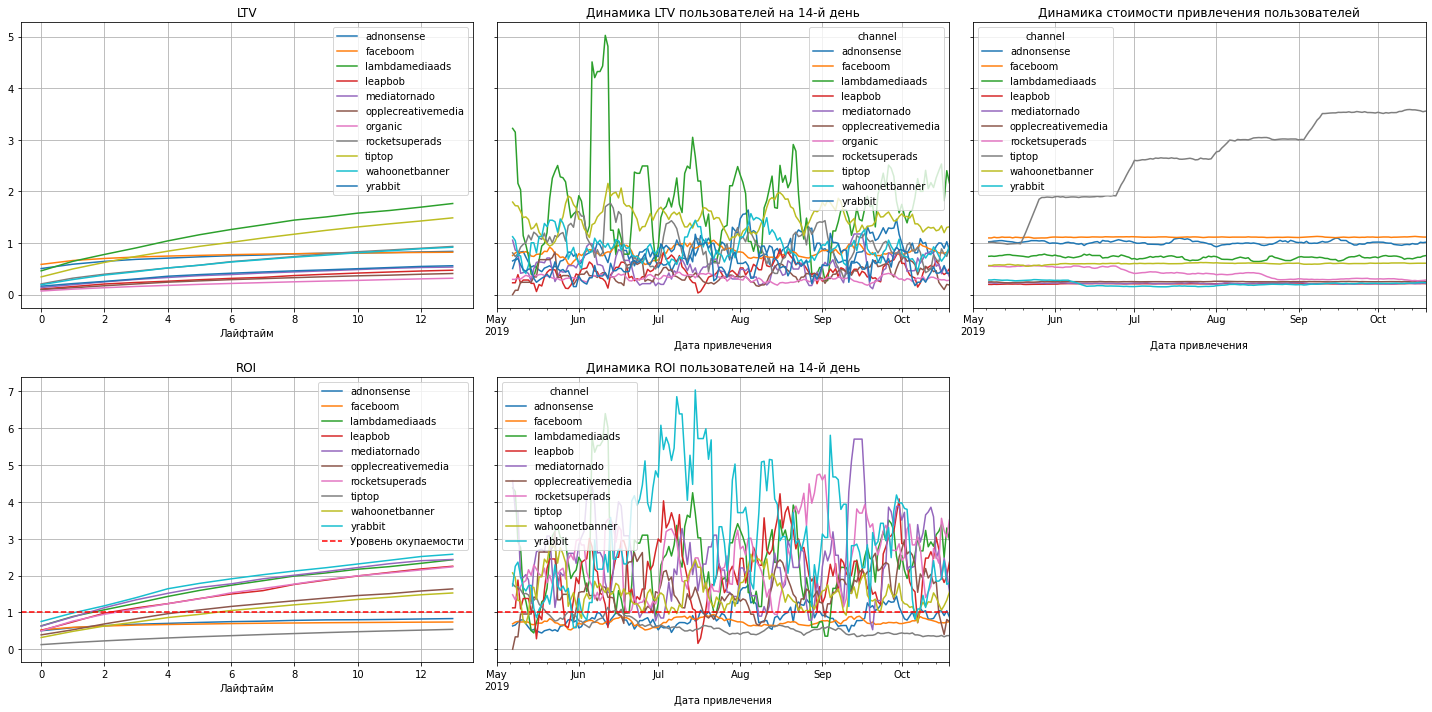

In [50]:
# смотрим LTV, ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- По потенциалу доходности (LTV) опережает всех lambdamediaads (рынок Европы), а также Tiptop (рынок США)

- Только Tiptop, Faceboom (оба ориентированы на привлечение пользователей с рынка США, и действительно привлекли их количественно много) и Adnonsense (Европейский рынок) НЕ вышли на окупаемость.

- Обратим внимание на постоянно растущую стоимость привлечения через Tiptop, увеличивалась она ступенчато от месяца к месяцу (увеличивался рекламный бюджет на этот канал), но в итоге - пользователей привлекли даже меньше, чем faceboom, стоимость привлечения пользователя в котором была ниже и не менялась. 

- Обратим внимание на платформу yrabbit (рынок США) - стоимость привлечения - одна из самых низких, при этом здесь лучший показатель по окупаемости (помним, что и количество привлеченных пользователей на этой платформе не самое низкое.)



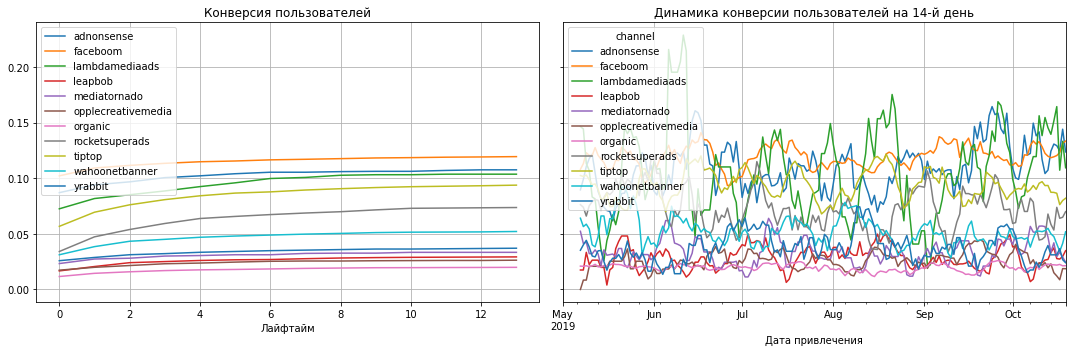

In [51]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


Конвертируются лучше всего faceboom, yrabbit, lambdamediaads, tiptop, wahoonetbanner.

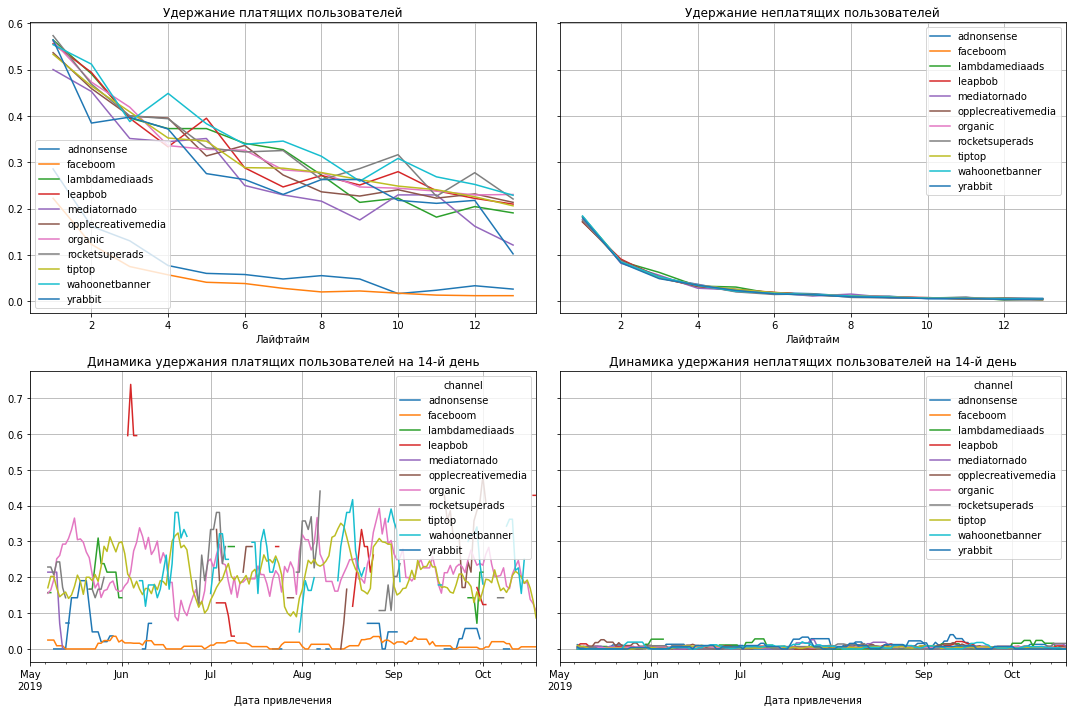

In [52]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Показатель удержания платящих пользователей сильно меньше у faceboom и yrabbit (обе ориентированы на рынок США), при этом удержание платящих пользователей на tiptop,  как и на оставшихся платформах заметно выше.

Выводы:
глобальная проблема все та же - удержание, ни одна из платформ не показывает "линейный" показатель, все идут на достаточно резкое для этого показателя снижение, ситуация с faceboom и yrabbit самая плачевная, а вот tiptop так сильно не западает. При этом TipTop - очень дорогой канал, тянущий деньги. FaceBoom приводит платящих пользователей с низким качеством, они быстро уходят.

### Окупаемость рекламы с разбивкой по устройствам

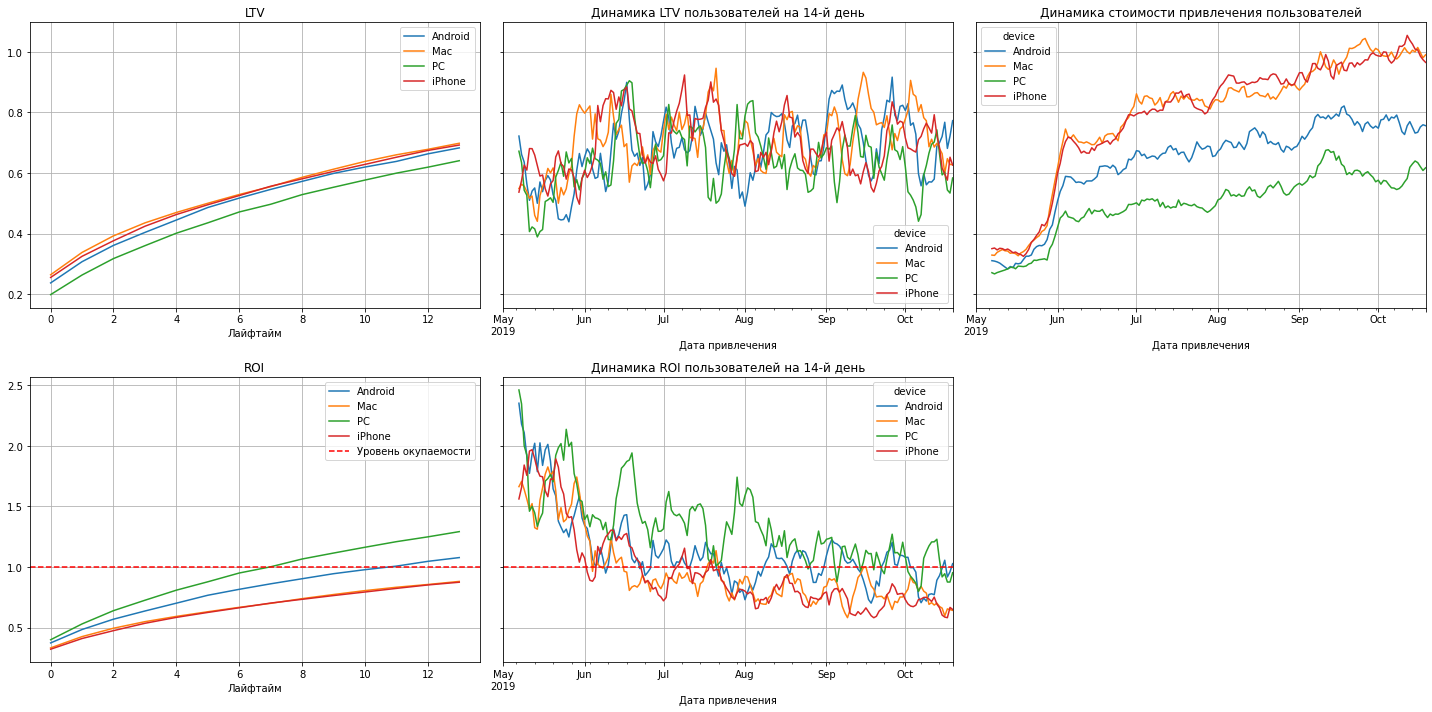

In [53]:
# смотрим LTV, ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По показателю пожизненной ценности клиента немного отстают владельцы PC. По стоимости привлечения пользователя заметно впереди владельцы техники Apple. При этом реклама для владельцев PC окупается на 5 день, для владельцев Android  - на 9 день. Реклама для владельцев девайсов от Apple не окупается совсем.

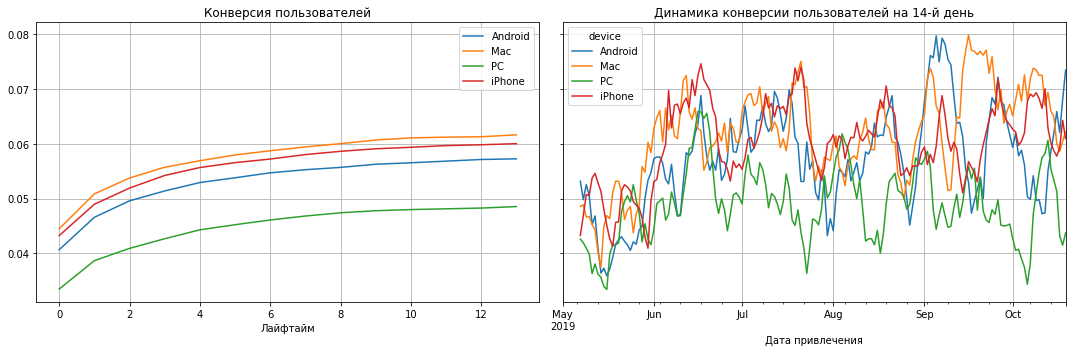

In [54]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


Конвертируются пользователи Apple лучше всего, хуже всего конвертиция у пользователей PC

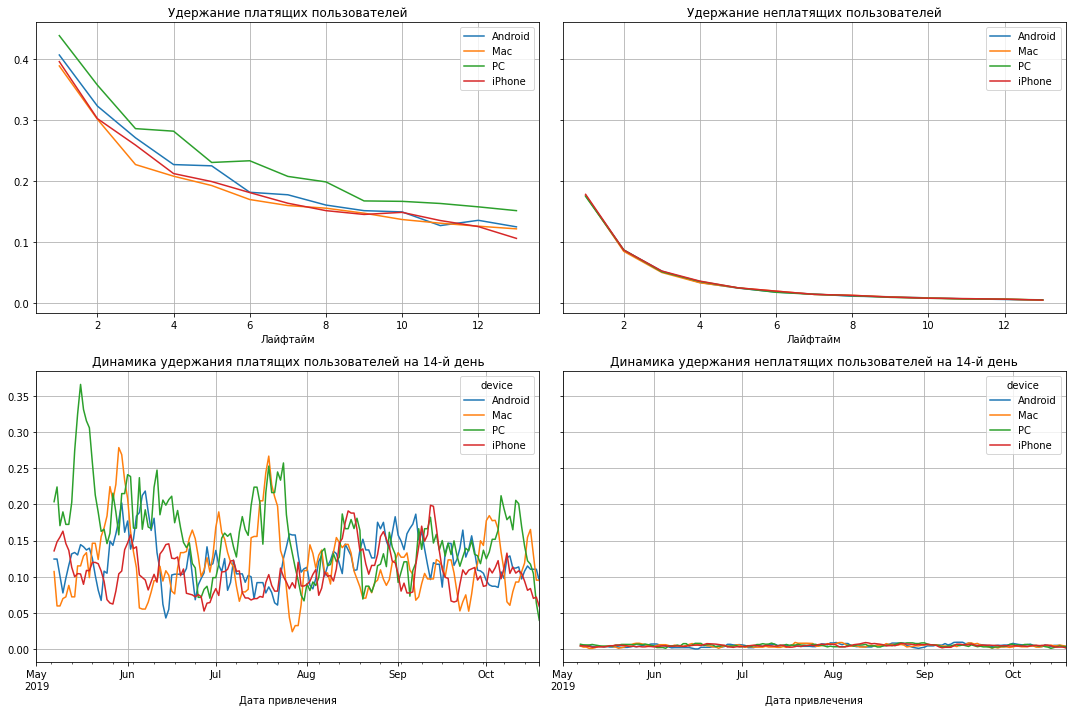

In [55]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание по всем девайсам примерно на одном уровне, но все же нельзя не отметить ранжирование: 1 место - pc, 2 место - Android, 3-4 место - iPhone и Mac

## Выводы

**На данный момент ситуация выглядит так:**

В рекламной стратегии было выделено два крупных сегмента - США и Европа. Ориентируясь на них были выбраны каналы привлечения (не пересекающиеся). Далее были вложены деньги. По итогам мая рекламный бюджет значительно увеличили на США - и это принесло свои плоды: большее количество пользователей пришло из платформ, ориентированных на американский рынок - faseboom, tiptop. На Европейский рынок рекламный бюджет немного сократили и не повышали далее.

С июня начались проблемы. Пользователи, пришедшие из Европы стабильно окупались, стоимость их привлечения оставалась низкой, НО привлечено их заметно меньше, чем в США и конвертируются они хуже. В это же время стоимость привлечения пользователя в США растет, количество пользователей из США намного больше, чем из Европы, конвертируются они лучше, но совсем не удерживаются, соответственно и не окупаются.

Главная проблема рекламной кампании - плохо сработали мероприятия, направленные на удержание клиентов (или их вообще не было).

Такое большое вложение рекламных денег в привлечение через tiptop лишь частично оправдало себя тем, что удержание в этом приложении среднее для всех платформ. А вот с выбором рекламной площадкой faceboom точно попали в целевую аудиторию, за меньшие деньги привлекли больше пользователей (чем tiptop), но при этом пользователи совсем не удерживались.

По показателю удержания в разрезе устройств мы видим, что какого-то аномально низкого показателя нет, больших технических проблем скорее всего не возникало, но показатель также ползет вниз - можно улучшаться и технически.

**Рекомендации:**

**Начать плотно работат по удержанию клиентов по всем направлениям**

Мероприятия по удержанию клиентов увеличивают их пожизненную ценность, а значит помогут выйти на прибыль.

В первую очередь нужно:
1. Пересмотреть рекламную кампанию, ориентированную на американский рынок (особенно на платформы faseboom, tiptop, yrabbit) - выделять деньги не только на привлечение, но и мероприятия/действия/техническое усовершенствование по удержанию клиентов (особенно на faseboom): посмотреть как работают и работают ли почтовые рассылки, push-уведомления, чат-боты и т.д. 

2. Еще раз посмотреть описание целевой аудитории приложения, сравнить с реально полученной аудиторией faceboom, tiptop и органиков (самое большое количество пользователей из этих источников), при необходимости внести корректировки в список рекламных площадок (в т. ч. список европейских площадок - может быть низкий показатель количества привлечченных пользователей здесь связан именно с непопаданием в целевую аудиторию)

3. Посмотреть входную страницу приложения, проанализировать -  все ли пользователям удобно, может быть прошло обновление, которое "не прижилось"?

4. Подготовить детальный план мероприятий по удержанию клиентов, который будет входить в общую рекламную стратегию (включить в него, например: можно ввести определённые "награды" или привилегии для постоянных пользователей, для канала FaceBoom можно настроить более таргетированное привлечение, направленное на пользователей с необходимыми характеристиками. Можно ввести поощрение пользователей за репосты контента и прочий социальный engagement, связанный с приложением, в данном канале)

